<a href="https://colab.research.google.com/github/changhorang/SSAC_study/blob/main/DL/07_CNN_MNIST%EB%B6%84%EB%A5%98%2C_%EB%AA%A8%EB%8D%B8%EC%A0%80%EC%9E%A5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Convolutional Neural Network 구현

- MNIST 손글씨 data를 이용하여 CNN을 학습하고 MLP와 결과와 비교 해본다.

##### 학습결과 시각화 함수 정의

In [ ]:
!nvidia-smi

Mon Dec  6 08:02:00 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.44       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   51C    P8    33W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [1]:
import matplotlib.pyplot as plt

# loss 그래프
def plot_loss(history):
    plt.plot(history.history['loss'], label='Train loss')
    plt.plot(history.history['val_loss'], label='Validation loss')
    plt.title('Loss')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend()
    plt.show()

In [2]:
# accuracy 그래프
def plot_accuracy(history):
    plt.plot(history.history['accuracy'], label='Train accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation accuracy')
    plt.title('Accuracy')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.legend()
    plt.show()

# MNIST CNN 적용

In [4]:
import os
import numpy as np

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

print(tf.__version__)
print(keras.__version__)

2.7.0
2.7.0


In [5]:
np.random.seed(0)
tf.random.set_seed(0)

##### data loading

In [6]:
(train_image, train_label), (test_image, test_label) = keras.datasets.mnist.load_data()
train_image.shape, test_image.shape
# (60000, 28, 28) - (개수, height, width) => channel 축이 없으므로 늘릴 것!

11501568/11490434 [==============================] - 0s 0us/step


((60000, 28, 28), (10000, 28, 28))

##### 하이퍼파라미터, 변수 설정

In [7]:
LEARNING_RATE = 0.001
N_EPOCHS = 20
N_BATCHS = 100

N_TRAIN = train_image.shape[0]
N_TEST = test_image.shape[0]

##### 전처리, Dataset 생성
- X: 0 ~ 1 scaling
    - gray scale 일 경우 channel 축을 늘려줘야 한다. (h, w, 1)
- Y: onehot encoding

In [8]:
# X: 0 ~ 1 scaling
X_train_tmp = (train_image/255.0).astype(np.float32)
X_test_tmp = (test_image/255.0).astype(np.float32)

# channel 축을 추가
# ...: 원래 shape, np.newaxis는 크기가 1인 axis 추가
X_train = X_train_tmp[..., np.newaxis] # (60000, 28, 28, 1)
X_test = X_test_tmp[..., np.newaxis]
X_train.shape, X_test.shape

((60000, 28, 28, 1), (10000, 28, 28, 1))

In [9]:
# y: onehot-encoding
y_train = keras.utils.to_categorical(train_label)
y_test = keras.utils.to_categorical(test_label)

###### Dataset 생성

In [10]:
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train)).shuffle(N_TRAIN).batch(N_BATCHS, drop_remainder=True)

test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test)).batch(N_BATCHS)

## Model(Network) 정의
- Feature Extraction(backbone):Convolution Layer
    - block: Convolution + MaxPooling Layer
    - size(height, width) 는 줄이고 channel은 늘리는 방향으로 Layer들을 쌓는다.
    - convolution
        - size: 3 X 3
        - strides: 1
    - max pooling
        - size: 2 X 2
        - strides: 2
- 분류기
    - Dense Layer 사용        
    - Flatten을 먼저 해야 한다. (Conv의 output-feature map- 3차원 배열)


In [11]:
def create_mnist_model():
    model = keras.Sequential()

    model.add(layers.InputLayer((28, 28, 1))) # Conv2D의 input은 3차원 (h, w, c)

    model.add(layers.Conv2D(filters=32,         # filter의 개수
                            kernel_size=(3,3),  # filter size (h, w)
                            padding='same',     # input과 output(feature map) size가 동일하도록 zero-padding 추가 [default:'valid']
                            strides=(1,1),      # conv 연산시 이동 보폭 (좌우, 상하) [default=1]
                            activation='relu'   # conv연산 결과를 넣어줄 활성함수
                            ))
    
    model.add(layers.MaxPool2D(pool_size=(2,2), # (2, 2) 영역에서 가장 큰 값 하나를 추출 [default: (2, 2)]
                               strides=(2,2),   # 이동 보폭. [default:none] / pool_size의 설정과 동일한 크기
                               padding='same')) # [default: valid] / 나머지 짜투리 영역은 버림
                                                # same - 짜투리 영역에서도 가장 큰 값을 추출

    model.add(layers.Conv2D(filters=64,         # 필터 개수는 늘리기
                            kernel_size=3,      # (h, w) - h, w 크기가 같은 경우, 값 하나만 지정
                            padding='same',
                            activation='relu'
                            ))
    
    model.add(layers.MaxPool2D(padding='same')) # pool_size/stride는 default((2, 2), None) 사용
                                                # padding - default : valid

    model.add(layers.Conv2D(filters=128, kernel_size=3, padding='same', activation='relu'))
    model.add(layers.MaxPool2D(padding='same'))

    # 출력 feature map 하나의 shape => 3차원 (h, w, c)
    model.add(layers.Flatten()) # 3차원 => 1차원
    # Dense layer의 입력의 shape -> 1차원
    # Hidden layer 추가
    model.add(layers.Dense(units=256, activation='relu'))

    # soft max를 통해 각 라벨에 해당하는 확률 구함
    model.add(layers.Dense(units=10, activation='softmax'))

    return model

##### 컴파일

In [ ]:
model = create_mnist_model()
model.compile(optimizer=keras.optimizers.Adam(learning_rate=LEARNING_RATE), 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 14, 14, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 7, 7, 64)         0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 7, 7, 128)         73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 4, 4, 128)        0

In [ ]:
# conv 파라미터 개수 계산
# (filter_width*filter_height)*input_channel*filter개수 +  filter개수(bias)
# 1번 conv
print(3*3*1*32+32)
# 2번 conv 파라미터
print(3*3*32*64+64)

320
18496


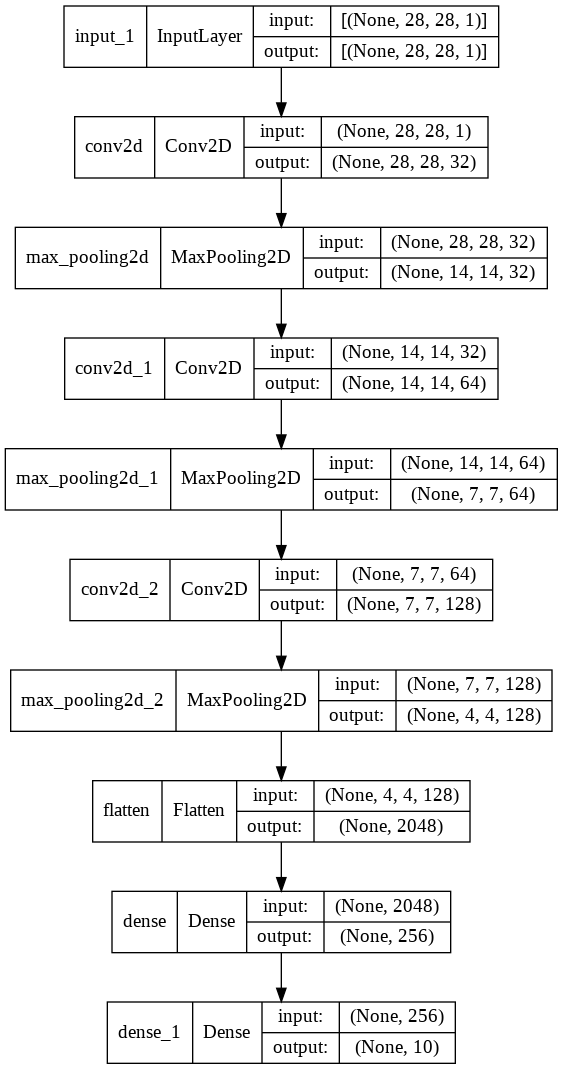

In [ ]:
keras.utils.plot_model(model, show_shapes=True)

##### 학습

In [ ]:
hist = model.fit(train_dataset, 
                 epochs=N_EPOCHS, 
                 validation_data=test_dataset)

Epoch 1/20
600/600 [==============================] - 21s 14ms/step - loss: 0.1623 - accuracy: 0.9499 - val_loss: 0.0414 - val_accuracy: 0.9854
Epoch 2/20
600/600 [==============================] - 8s 13ms/step - loss: 0.0457 - accuracy: 0.9860 - val_loss: 0.0341 - val_accuracy: 0.9886
Epoch 3/20
600/600 [==============================] - 8s 14ms/step - loss: 0.0308 - accuracy: 0.9904 - val_loss: 0.0322 - val_accuracy: 0.9892
Epoch 4/20
600/600 [==============================] - 8s 13ms/step - loss: 0.0236 - accuracy: 0.9924 - val_loss: 0.0257 - val_accuracy: 0.9915
Epoch 5/20
600/600 [==============================] - 8s 13ms/step - loss: 0.0189 - accuracy: 0.9938 - val_loss: 0.0320 - val_accuracy: 0.9905
Epoch 6/20
600/600 [==============================] - 8s 12ms/step - loss: 0.0161 - accuracy: 0.9948 - val_loss: 0.0192 - val_accuracy: 0.9928
Epoch 7/20
600/600 [==============================] - 8s 12ms/step - loss: 0.0124 - accuracy: 0.9960 - val_loss: 0.0239 - val_accuracy: 0.992

##### 결과시각화

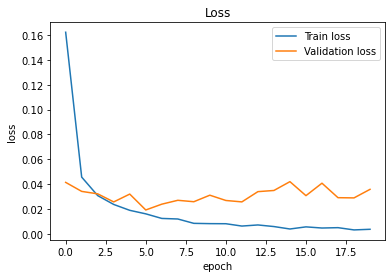

In [ ]:
plot_loss(hist)

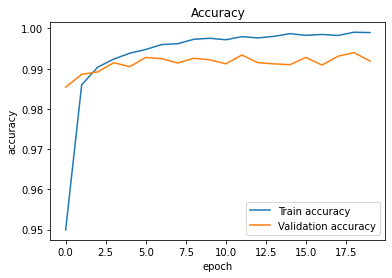

In [ ]:
plot_accuracy(hist)

##### 최종검증

In [ ]:
loss, acc = model.evaluate(test_dataset)

100/100 [==============================] - 1s 6ms/step - loss: 0.0358 - accuracy: 0.9919


In [ ]:
print(loss, acc)

0.03580016642808914 0.9919000267982483


## prediction error가 발생한 example 확인
- test dataset으로 예측한 결과중 틀린 것들을 확인해 본다.

In [ ]:
pred = model.predict(X_test)
pred.shape

(10000, 10)

In [ ]:
pred[:5, :4]

array([[4.2364711e-20, 1.0941594e-12, 2.7411042e-17, 6.5873679e-13],
       [9.1945546e-10, 2.1903275e-09, 1.0000000e+00, 1.0680250e-15],
       [4.4137792e-12, 1.0000000e+00, 6.6013915e-13, 3.7151407e-14],
       [1.0000000e+00, 7.3477263e-18, 8.2554743e-18, 1.4856377e-14],
       [1.8352796e-15, 1.0098488e-10, 5.5650370e-14, 4.2966380e-14]],
      dtype=float32)

In [ ]:
pred_label = np.argmax(pred, axis=-1)
pred_label.shape

(10000,)

In [ ]:
# test_label(target) 와 pred_label(prediction) 간에 틀린 것의 index를 조회
idx = np.where(test_label != pred_label)[0]
idx.shape

(81,)

In [ ]:
# index별 틀린 것 조회
idx[:5]

array([ 18, 115, 160, 247, 321])

##### confusion matrix 확인

In [ ]:
from sklearn.metrics import confusion_matrix, plot_confusion_matrix, ConfusionMatrixDisplay

confusion_matrix(test_label, pred_label)

array([[ 974,    1,    0,    0,    0,    1,    3,    1,    0,    0],
       [   0, 1134,    0,    0,    0,    1,    0,    0,    0,    0],
       [   1,    1, 1023,    0,    0,    0,    0,    6,    1,    0],
       [   0,    0,    0, 1004,    0,    5,    0,    0,    1,    0],
       [   0,    2,    0,    0,  967,    0,    1,    0,    1,   11],
       [   0,    0,    0,    3,    0,  888,    1,    0,    0,    0],
       [   2,    2,    0,    0,    0,    0,  951,    0,    3,    0],
       [   0,    4,    0,    1,    0,    0,    0, 1020,    1,    2],
       [   0,    0,    1,    1,    0,    0,    0,    0,  971,    1],
       [   0,    0,    0,    3,    4,    3,    0,    6,    6,  987]])

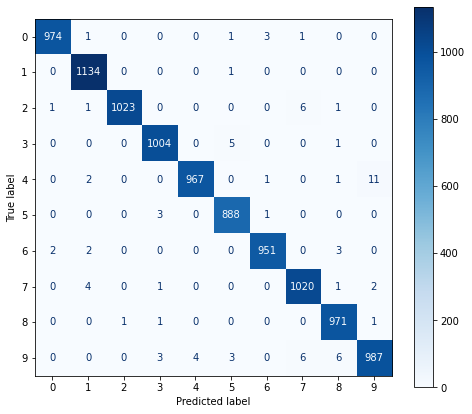

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,7))
ax = plt.gca()

cm = confusion_matrix(test_label, pred_label)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues', ax=ax, values_format='d')
plt.show()

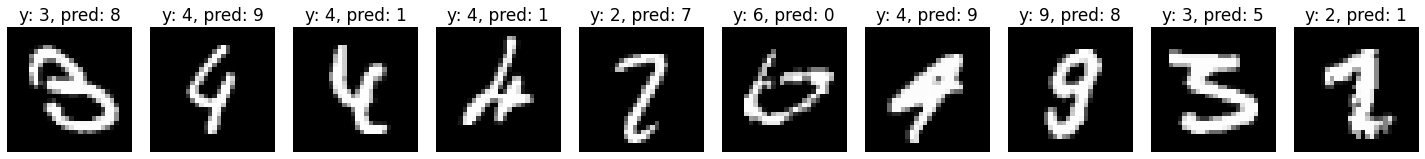

In [ ]:
# 틀린 결과 중에 10개 확인
import matplotlib.pyplot as plt

plt.figure(figsize=(20, 20))

for i in range(10):  
   
    error_idx = idx[i]
    
    p = pred_label[error_idx] # 추론 결과들
    y = test_label[error_idx] # targets

    plt.subplot(1, 10, i+1)
    plt.imshow(test_image[error_idx], cmap='gray')
    plt.title(f"y: {y}, pred: {p}", fontsize=17)
    plt.axis('off')

plt.tight_layout()
plt.show()

# 학습한 모델 파일로 저장

- **무엇을 저장할 지**
    1. Train이 끝난 모델의 파라미터만 저장
    1. 모델 구조와 파라미터 모두 저장

- **저장시점**
    1. Train 완료된 모델을 저장
    1. Callback을 이용해 Train 도중 가장 성능이 좋은 시점의 모델을 저장

## 텐서플로 저장 파일 타입
- checkpoint 
    - 모델의 weight를 저장하기 위한 타입
- SavedModel 
    - 모델의 구조와 파라미터들을 모두 저장하는 타입

## 학습한 Weight (파라미터) 저장 및 불러오기
- 가중치를 저장하여 나중에 재학습 없이 학습된 가중치를 사용할 수 있다.
- 저장
    - `model.save_weights("저장경로")`
- 불러오기
    - `model.load_weights('불러올경로')`
- 저장형식
    - Tensorflow Checkpoint (기본방식)
    - HDF5
        - `save_weights(.., save_format='h5')`
        - 또는 파일 확장자를 h5로 지정한다.

### Checkpoint 으로 저장

##### 저장할 경로 생성및 저장

In [12]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [13]:
import os

base_dir = "/content/drive/MyDrive/DL/saved_models"

if not os.path.isdir(base_dir): # base_dir directory 없으면 만들기
  os.mkdir(base_dir)

# 모델의 weight들을 저장할 directory명
mnist_weight_dir = os.path.join(base_dir, "mnist_weight") 
print(mnist_weight_dir)

if not os.path.isdir(mnist_weight_dir):
    os.mkdir(mnist_weight_dir)
    
weight_file_path = os.path.join(mnist_weight_dir, "mnist_weight_ckpt")

print(weight_file_path)

/content/drive/MyDrive/DL/saved_models/mnist_weight
/content/drive/MyDrive/DL/saved_models/mnist_weight/mnist_weight_ckpt


In [ ]:
model.save_weights(weight_file_path) # parameter들만 저장

In [14]:
# loading시에는 먼저 모델 네트워크 구조부터 생성
new_model = create_mnist_model()
new_model.compile(optimizer=keras.optimizers.Adam(learning_rate=LEARNING_RATE), loss='categorical_crossentropy', 
                  metrics=['accuracy'])

In [15]:
new_model.evaluate(test_dataset) # 아직 학습이 안되었기 때문에 성능이 낮음

100/100 [==============================] - 9s 7ms/step - loss: 2.3006 - accuracy: 0.1018


[2.300644636154175, 0.10180000215768814]

In [16]:
# new_model에 학습된(저장된) parameter들을 읽어와서 덮기
new_model.load_weights(weight_file_path)

In [17]:
new_model.evaluate(test_dataset)

100/100 [==============================] - 1s 7ms/step - loss: 0.0358 - accuracy: 0.9919


[0.03580016642808914, 0.9919000267982483]

### h5 형식으로 저장

In [18]:
weight_h5_dir = os.path.join(base_dir, "mnist_weight_h5")
if not os.path.isdir(weight_h5_dir):
    os.makedirs(weight_h5_dir, exist_ok=True)
weight_h5_path = os.path.join(weight_h5_dir, "mnist_weight.h5")

In [ ]:
model.save_weights(weight_h5_path, save_format='h5')

In [19]:
new_model = create_mnist_model()
new_model.compile(optimizer=keras.optimizers.Adam(LEARNING_RATE),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

In [ ]:
# 학습이 아직 안된 상태의 모델 평가
new_model.evaluate(test_dataset)

100/100 [==============================] - 1s 7ms/step - loss: 2.3001 - accuracy: 0.0936


[2.3000831604003906, 0.09359999746084213]

In [20]:
# new_model에 저장된 weights(parameter)를 덮어씀
new_model.load_weights(weight_h5_path)

In [21]:
# weights 덮어쓴 후 평가
new_model.evaluate(test_dataset)

100/100 [==============================] - 1s 7ms/step - loss: 0.0358 - accuracy: 0.9919


[0.03580016642808914, 0.9919000267982483]

## 전체 모델 저장하고 불러오기
- https://www.tensorflow.org/guide/keras/save_and_serialize?hl=ko
- 저장
    - `model.save('저장할디렉토리')`
- 불러오기
    - `tf.keras.models.load_model('저장된디렉토리')`
- 저장 형식
    - Tensorflow SavedModel 형식(기본방식)
        - 모델 아키텍처 및 훈련 구성(옵티마이저, 손실 및 메트릭 포함)은 saved_model.pb 에 저장된다.
        - 파라미터는 variables/ 디렉토리에 저장된다.
        - https://www.tensorflow.org/guide/saved_model?hl=ko#the_savedmodel_format_on_disk
    - HDF5 형식
        - `save(..., save_format='h5')` 
        - 또는 파일의 확장자를 h5로 지정한다.

###  Saved Model 형식으로 모델 저장
- 경로(디렉토리) 만 지정한다.

In [22]:
mnist_model_dir = os.path.join(base_dir, 'mnist_model')
print(mnist_model_dir, type(mnist_model_dir))
if not os.path.isdir(mnist_model_dir):
    os.mkdir(mnist_model_dir) 

/content/drive/MyDrive/DL/saved_models/mnist_model <class 'str'>


In [ ]:
# weight + 모델 구조 저장 : saved_model 형식으로 저장(기본) => 저장할 directory만 지정
model.save(mnist_model_dir)

INFO:tensorflow:Assets written to: /content/drive/MyDrive/DL/saved_models/mnist_model/assets


In [23]:
# 저장된 model구조 + parameter loading
new_model2 = keras.models.load_model(mnist_model_dir)

In [24]:
new_model2.evaluate(test_dataset)

100/100 [==============================] - 1s 7ms/step - loss: 0.0358 - accuracy: 0.9919


[0.03580016642808914, 0.9919000267982483]

### H5 형식으로 모델 저장

In [25]:
model_h5_dir = os.path.join(base_dir, 'mnist_model_h5')

if not os.path.join(model_h5_dir):
    os.makedirs(model_h5_dir, exist_ok=True)

model_h5_path = os.path.join(model_h5_dir, "mnist_model.h5") # h5형식: 파일명까지 지정

In [ ]:
model.save(model_h5_path, save_format='h5')

In [26]:
new_model3 = keras.models.load_model(model_h5_path)

new_model3.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 14, 14, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 7, 7, 64)         0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 7, 7, 128)         73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 4, 4, 128)        0

In [27]:
new_model3.evaluate(test_dataset)

100/100 [==============================] - 1s 7ms/step - loss: 0.0358 - accuracy: 0.9919


[0.03580016642808914, 0.9919000267982483]

## Callback을 사용한 모델 저장 및 Early Stopping
- callback은 학습하는 도중 특정 이벤트 발생시 호출되는 다양한 함수를 제공하여 자동화 처리를 지원한다. (cf: 프로그래밍의 콜백함수)
- 다양한 콜백 클래스가 제공된다.
    - https://www.tensorflow.org/api_docs/python/tf/keras/callbacks
- ### ModelCheckpoint
    - 각 epoch 마다 학습한 모델과 weight(또는 weight만)를 저장한다. 
    - 지정한 평가지표(예:validation loss)가 가장 좋을 때 모델과 weight만 저장할 수 있다.
    - 주요 파라미터
        - `save_weights_only=True`: True: 파라미터(weight)만 저장한다. False: 모델구조와 파라미터 모두 저장한다.
        - `save_best_only=True`: 학습중 성능이 개선될 때만 저장한다. (False:기본값 - 모든 에폭마다 저장한다.)
- ### EarlyStopping
    - Validation set에 대한 평가지표가  더 이상 개선되지 않을 때 학습을 자동으로 멈추는 callback
    - 주요 파라미터
        - `monitor`: 모니터링할 평가지표 지정. (ex: accuracy)
        - `patience`: epoch 수 지정. validation 평가 지표가 개선이 안되더라도 지정한 epoch만큼 반복한다. 지정한 epoch만큼 반복 후에도 개선이 되지 않으면 중단한다. 

- **callback 객체들을 리스트로 묶은 뒤 fit()의 callbacks 매개변수에 전달한다.**

In [28]:
model2 = create_mnist_model()
model2.compile(optimizer='adam', 
               loss='categorical_crossentropy', 
               metrics=['accuracy'])

In [29]:
model2.evaluate(test_dataset)

100/100 [==============================] - 1s 7ms/step - loss: 2.3044 - accuracy: 0.1003


[2.304438591003418, 0.10029999911785126]

In [30]:
# callback을 이용해 모델을 저장할 때 저장할 디렉토리 생성 및 경로 문자열로 저장
checkpoint_save_dir = os.path.join(base_dir, 'mnist_callback')
if not os.path.isdir(checkpoint_save_dir):
    os.mkdir(checkpoint_save_dir)

checkpoint_save_file = os.path.join(checkpoint_save_dir, 'mnist_ckpt')

In [31]:
# 저장경로: parameter만 저장할 경우 파일명까지, 모델구조+weight를 저장할 경우 directory까지 설정
mc_callback = keras.callbacks.ModelCheckpoint(filepath=checkpoint_save_file, # save directory
                          save_best_only=True, # 성능이 개선된 경우에 계속 덮어쓰면서 저장
                          monitor='val_loss',  # 어떤 성능 개선일 때 저장할 지 모니터링할 평가지표
                          # save_weights_only=True, # parameter(weight)만 저장 [default: False]
                          verbose=1) # 저장할 때 로그 출력

In [33]:
es_callback = keras.callbacks.EarlyStopping(monitor='val_loss', # 모니터링할 평가지표
                                            patience=5, # 지정한 epoch만 지나도록 개선이 안되면 train stop (general 5~10)
                                            verbose=1)  # log 출력 (멈춘 이유 description)

In [34]:
hist = model2.fit(train_dataset, epochs=N_EPOCHS, validation_data=test_dataset,
                  callbacks=[mc_callback, es_callback])

Epoch 1/20
598/600 [============================>.] - ETA: 0s - loss: 0.1589 - accuracy: 0.9517
Epoch 00001: val_loss improved from inf to 0.04176, saving model to /content/drive/MyDrive/DL/saved_models/mnist_callback/mnist_ckpt
INFO:tensorflow:Assets written to: /content/drive/MyDrive/DL/saved_models/mnist_callback/mnist_ckpt/assets
600/600 [==============================] - 13s 19ms/step - loss: 0.1585 - accuracy: 0.9518 - val_loss: 0.0418 - val_accuracy: 0.9863
Epoch 2/20
598/600 [============================>.] - ETA: 0s - loss: 0.0431 - accuracy: 0.9866
Epoch 00002: val_loss improved from 0.04176 to 0.04021, saving model to /content/drive/MyDrive/DL/saved_models/mnist_callback/mnist_ckpt
INFO:tensorflow:Assets written to: /content/drive/MyDrive/DL/saved_models/mnist_callback/mnist_ckpt/assets
600/600 [==============================] - 11s 18ms/step - loss: 0.0430 - accuracy: 0.9867 - val_loss: 0.0402 - val_accuracy: 0.9871
Epoch 3/20
598/600 [============================>.] - ETA:

In [35]:
new_model3 = keras.models.load_model(checkpoint_save_file)

In [36]:
new_model3.evaluate(test_dataset)

100/100 [==============================] - 1s 7ms/step - loss: 0.0240 - accuracy: 0.9922


[0.02403249964118004, 0.9922000169754028]

In [ ]:
# 파라미터만 저장

In [37]:
# callback을 이용해 모델을 저장할 때 저장할 디렉토리 생성 및 경로 문자열로 저장
checkpoint_save_dir = os.path.join(base_dir, 'mnist_callback_weight')
if not os.path.isdir(checkpoint_save_dir):
    os.mkdir(checkpoint_save_dir)

checkpoint_save_file = os.path.join(checkpoint_save_dir, 'mnist_ckpt')
# 매 epoch마다 저장할 경우, 파일명에 저장 epoch 값이 들어가도록 파일경로에 {epoch} 형식문자를 추가
# checkpoint_save_file = os.path.join(checkpoint_save_dir, 'mnist_ckpt_{epoch:03d}')

In [38]:
# 저장경로: parameter만 저장할 경우 파일명까지, 모델구조+weight를 저장할 경우 directory까지 설정
mc_callback = keras.callbacks.ModelCheckpoint(filepath=checkpoint_save_file, # save directory
                          save_best_only=True, # 성능이 개선된 경우에 계속 덮어쓰면서 저장
                          # default: False인 경우, epoch마다 저장
                          monitor='val_loss',  # 어떤 성능 개선일 때 저장할 지 모니터링할 평가지표
                          save_weights_only=True, # parameter(weight)만 저장 [default: False]
                          verbose=1) # 저장할 때 로그 출력

es_callback = keras.callbacks.EarlyStopping(monitor='val_loss', # 모니터링할 평가지표
                                            patience=5, # 지정한 epoch만 지나도록 개선이 안되면 train stop (general 5~10)
                                            verbose=1)  # log 출력 (멈춘 이유 description)

In [39]:
model2 = create_mnist_model()
model2.compile(optimizer='adam', 
               loss='categorical_crossentropy', 
               metrics=['accuracy'])

In [40]:
hist = model2.fit(train_dataset, epochs=N_EPOCHS, validation_data=test_dataset,
                  callbacks=[mc_callback, es_callback])

Epoch 1/20
598/600 [============================>.] - ETA: 0s - loss: 0.1617 - accuracy: 0.9504
Epoch 00001: val_loss improved from inf to 0.05309, saving model to /content/drive/MyDrive/DL/saved_models/mnist_callback_weight/mnist_ckpt
600/600 [==============================] - 10s 16ms/step - loss: 0.1614 - accuracy: 0.9506 - val_loss: 0.0531 - val_accuracy: 0.9815
Epoch 2/20
598/600 [============================>.] - ETA: 0s - loss: 0.0429 - accuracy: 0.9868
Epoch 00002: val_loss improved from 0.05309 to 0.02926, saving model to /content/drive/MyDrive/DL/saved_models/mnist_callback_weight/mnist_ckpt
600/600 [==============================] - 10s 16ms/step - loss: 0.0430 - accuracy: 0.9867 - val_loss: 0.0293 - val_accuracy: 0.9898
Epoch 3/20
599/600 [============================>.] - ETA: 0s - loss: 0.0301 - accuracy: 0.9903
Epoch 00003: val_loss did not improve from 0.02926
600/600 [==============================] - 10s 16ms/step - loss: 0.0301 - accuracy: 0.9902 - val_loss: 0.0301 -